In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [ ]:
# Load dataset
df = pd.read_csv("species_biome_env_dataset.csv")

# Biome label lookup
biome_lookup = {
    1: "Tropical Forest", 2: "Temperate Forest", 3: "Boreal Forest",
    4: "Tropical Grassland", 5: "Temperate Grassland", 6: "Desert",
    7: "Shrubland", 8: "Tundra", 9: "Flooded Grassland", 10: "Mangroves",
    11: "Mediterranean", 12: "Montane", 13: "Xeric Shrubland", 14: "Ice and Rock"
}

species_cols = [
    "axolotl", "blue_macaw", "ocelot", "black_iguana", "resplendent_quetzal",
    "coyote", "crested_caracara", "green_turtle", "american_alligator", "asian_elephant"
]

biome_ids = sorted(df["BIOME"].dropna().unique())
compatibility_matrix_logreg = pd.DataFrame(index=species_cols, columns=[biome_lookup.get(b, f"Biome {b}") for b in biome_ids])

# Initialize matrix and metrics storage
compatibility_matrix_logreg_tuned = pd.DataFrame(index=species_cols, columns=[biome_lookup.get(b, f"Biome {b}") for b in biome_ids])
tuned_metrics = []

# Scoring and param grid
f1_scorer = make_scorer(f1_score, zero_division=0)
param_grid = {
    "C": [0.1, 1.0, 10.0],
    "penalty": ["l2"],
    "class_weight": ["balanced"],
    "solver": ["liblinear"]
}


In [ ]:
# Tuning loop
for species in species_cols:
    print(f"\n Tuning Logistic Regression for: {species}")
    y = df[species].astype(int)

    env_cols = [col for col in df.columns if col.startswith("BIO")]
    biome_encoded = pd.get_dummies(df["BIOME"], prefix="BIOME")
    X = pd.concat([df[env_cols], biome_encoded], axis=1)
    X = X.apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean(numeric_only=True))
    y = y.loc[X.index]

    if y.value_counts().min() < 2:
        print(f"Skipping {species} due to insufficient class diversity.")
        continue

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.25, random_state=42, stratify=y
        )
    except ValueError as ve:
        print(f"Skipping {species} — split error: {ve}")
        continue

    grid = GridSearchCV(
        LogisticRegression(max_iter=500),
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1
    )

    try:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    except Exception as e:
        print(f"Training failed for {species}: {e}")
        continue

    y_pred = best_model.predict(X_test)
    probas = best_model.predict_proba(X_scaled)[:, 1]

    print(f"Best F1: {f1_score(y_test, y_pred):.3f} | Params: {grid.best_params_}")

    tuned_metrics.append({
        "Species": species,
        "Model": "Logistic Regression (Tuned)",
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0)
    })

    # Compatibility matrix
    df_temp = df.loc[X.index].copy()
    df_temp["pred_prob"] = probas
    biome_avg = df_temp.groupby("BIOME")["pred_prob"].mean()

    for biome_id, prob in biome_avg.items():
        biome_label = biome_lookup.get(biome_id, f"Biome {biome_id}")
        compatibility_matrix_logreg_tuned.loc[species, biome_label] = round(prob, 3)


 Tuning Logistic Regression for: axolotl
Best F1: 0.025 | Params: {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: blue_macaw
Best F1: 0.267 | Params: {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: ocelot
Best F1: 0.583 | Params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: black_iguana
Best F1: 0.307 | Params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: resplendent_quetzal
Best F1: 0.132 | Params: {'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: coyote
Best F1: 0.833 | Params: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Logistic Regression for: crested_caracara
Best F1: 0.300 | Params: {'C': 0.1, 'class_weight': 

In [ ]:
# Save tuned metrics
tuned_logreg_df = pd.DataFrame(tuned_metrics)
tuned_logreg_df.to_csv("logreg_tuned_metrics.csv", index=False)

# Save new matrix
compatibility_matrix_logreg_tuned = compatibility_matrix_logreg_tuned.fillna("–")
compatibility_matrix_logreg_tuned.to_csv("logreg_tuned_matrix.csv")
display(compatibility_matrix_logreg_tuned)


<ipython-input-6-97339f6097f0>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  compatibility_matrix_logreg_tuned = compatibility_matrix_logreg_tuned.fillna("–")


,Tropical Forest,Temperate Forest,Boreal Forest,Tropical Grassland,Temperate Grassland,Desert,Shrubland,Tundra,Flooded Grassland,Mangroves,Mediterranean,Montane,Xeric Shrubland,Ice and Rock,Biome 26.265860931353888,Biome 98.0,Biome 99.0
axolotl,0.263,0.608,0.835,0.668,0.001,0.001,0.001,0.000,0.001,0.799,0.001,0.001,0.650,0.001,0.000,0.000,0.000
blue_macaw,0.645,0.441,0.000,0.123,0.185,0.000,0.874,0.138,0.935,0.000,0.000,0.477,0.080,0.092,0.000,0.245,0.000
ocelot,0.728,0.747,0.676,0.025,0.035,0.018,0.732,0.071,0.596,0.845,0.019,0.128,0.329,0.706,0.004,0.070,0.013
black_iguana,0.231,0.829,0.900,0.065,0.072,0.023,0.087,0.072,0.338,0.021,0.023,0.022,0.420,0.766,0.000,0.015,0.016
resplendent_quetzal,0.612,0.759,0.804,0.076,0.092,0.001,0.001,0.000,0.397,0.662,0.001,0.001,0.139,0.713,0.000,0.638,0.000
coyote,0.085,0.270,0.741,0.724,0.945,0.988,0.066,0.936,0.060,0.002,0.998,0.266,0.619,0.261,0.000,0.941,0.774
crested_caracara,0.579,0.758,0.646,0.211,0.134,0.019,0.572,0.195,0.650,0.800,0.021,0.020,0.494,0.715,0.006,0.287,0.016
green_turtle,0.583,0.598,0.470,0.365,0.269,0.016,0.489,0.178,0.575,0.471,0.016,0.880,0.561,0.898,1.000,0.051,0.012
american_alligator,0.153,0.063,0.101,0.733,0.803,0.161,0.563,0.452,0.589,0.000,0.000,0.188,0.301,0.082,0.000,0.226,0.000
asian_elephant,0.703,0.762,0.530,0.397,0.244,0.022,0.332,0.053,0.020,0.657,0.022,0.138,0.304,0.536,0.000,0.178,0.631


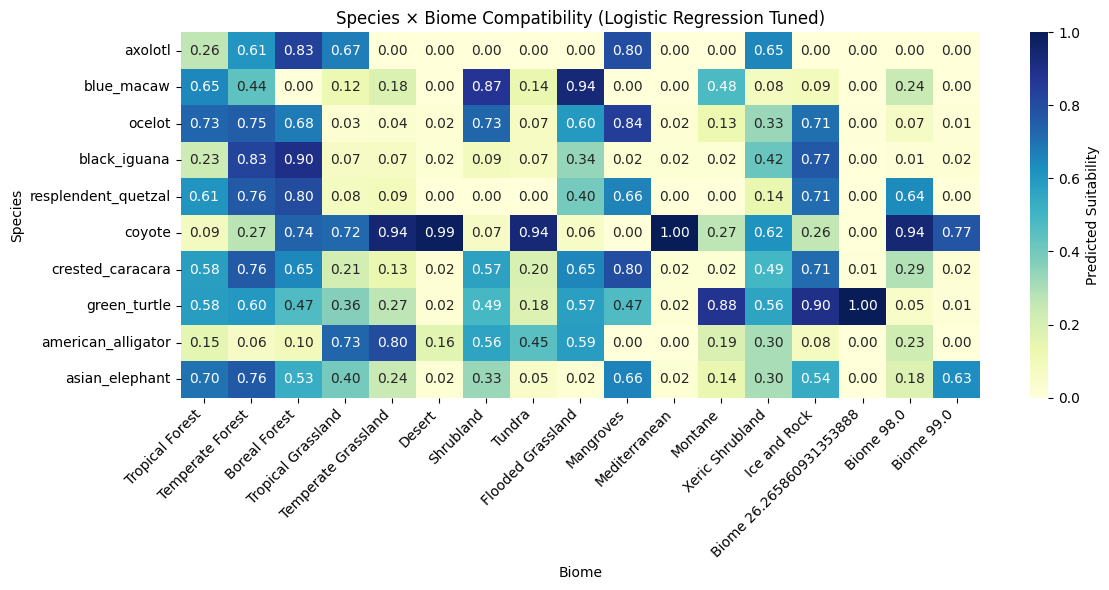

In [ ]:
# Mapa de calor

import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = compatibility_matrix_logreg_tuned.replace("–", np.nan).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Predicted Suitability"})
plt.title("Species × Biome Compatibility (Logistic Regression Tuned)")
plt.xlabel("Biome")
plt.ylabel("Species")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()